## Data Preprocessing and PyTorch Setup Imports


In [210]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

## Load Cleaned Classification Dataset


In [211]:
df = pd.read_csv('classification_dataset_clean.csv')

## Check Missing Values in Each Column


In [212]:
df.isna().sum()

Feature1          0
Feature2          0
NumFeature3    1000
CatFeature1     500
CatFeature2       0
Class             0
dtype: int64

## Define Preprocessing Pipelines for Categorical and Numerical Features


In [213]:
categorical_cols = df.select_dtypes('object').columns.tolist()
numerical_cols = df.select_dtypes(include='number').columns.drop('Class').tolist()
categorical_pipeline = Pipeline([
    ('nan', SimpleImputer(strategy='most_frequent')),
    ('tonum', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipeline = Pipeline([
    ('nan', SimpleImputer(strategy='median')),
])
preprocessor = ColumnTransformer(transformers=[
    ('categorical_cols', categorical_pipeline, categorical_cols),
    ('numerical_cols', numerical_pipeline, numerical_cols)
])


## Split Features and Target Variable


In [214]:
X = df[numerical_cols + categorical_cols]
y = df['Class']

## Fit Preprocessor and Transform Features


In [215]:
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

## Split Data into Training and Test Sets


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, train_size=0.8, random_state=123)

## Define a Simple Binary Classifier Neural Network in PyTorch


In [217]:
class binaryclassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(X_train.shape[1], 5)
        self.layer_2 = nn.Linear(5, 1)
    def forward(self, x):
        x = self.layer_1(x)
        x = nn.ReLU()(x)
        x = self.layer_2(x)
        x = nn.Sigmoid()(x)
        return x

## Set Device to GPU if Available and Move Model to Device

In [218]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = binaryclassifier().to(device)

## Convert Training Data to PyTorch Tensors


In [219]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32).to(device)

## Initialize Model, Loss Function, Optimizer, and Train for  1000 Epochs


In [220]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## Convert Test Data to PyTorch Tensors


In [221]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32).to(device)


## Evaluate Model on Test Data and Generate Binary Predictions


In [222]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred_labels = (y_pred_probs >= 0.5).float()


## Calculate and Print Test Accuracy


In [223]:
accuracy = (y_pred_labels == y_test_tensor).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")

Test Accuracy: 0.9990


## Display Class Distribution in the Dataset


In [224]:
print(df['Class'].value_counts(normalize=True))

Class
1    0.5022
0    0.4978
Name: proportion, dtype: float64


## Compute and Display Confusion Matrix for Test Predictions

In [225]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tensor, y_pred_labels)
print(cm)

[[ 998    1]
 [   1 1000]]


## Calculate and Print Precision, Recall, and F1 Score


In [226]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_tensor, y_pred_labels)
recall = recall_score(y_test_tensor, y_pred_labels)
f1 = f1_score(y_test_tensor, y_pred_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9990
Recall: 0.9990
F1 Score: 0.9990


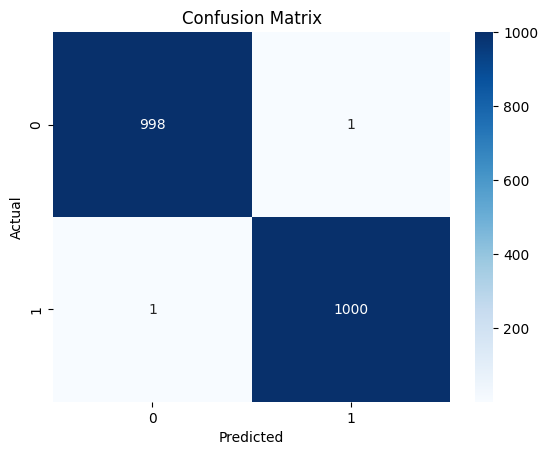

In [227]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_tensor, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Save PyTorch Model Weights


In [228]:
torch.save(model.state_dict(), 'model_weights.pth')
